In [1]:
from collections import deque
from copy import deepcopy
from pprint import pprint

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 32
LR = 0.00030
EPOCHS = 4
CLIP = 0.1
GAMMA = 0.99
LAMBDA = 0.95
ENT_COEF = 0.01
V_CLIP = True

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.pol = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v

In [4]:
losses = []


def learn(net, old_net, optimizer, train_memory):
    global CLIP
    net.train()
    old_net.train()

    for i in range(EPOCHS):
        dataloader = DataLoader(
            train_memory,
            shuffle=True,
            batch_size=BATCH_SIZE,
            pin_memory=use_cuda
        )
        for (s, a, _s, ret, adv) in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.detach().to(device).long()
            _s_batch = _s.to(device).float()
            ret_batch = ret.to(device).float()
            adv_batch = adv.to(device).float()
            batch_size = s_batch.shape[0]
            
            with torch.no_grad():
                log_p_batch_old, v_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(batch_size), a_batch]
                
            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(batch_size), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1. - CLIP, 1. + CLIP)
            p_loss = torch.min(p_ratio * adv_batch, p_ratio_clip * adv_batch).mean()
            
            if V_CLIP:
                v_clip = v_batch_old + torch.clamp(v_batch - v_batch_old, -CLIP, CLIP)
                v_loss1 = (ret_batch - v_clip).pow(2)
                v_loss2 = (ret_batch - v_batch).pow(2)
                v_loss = torch.max(v_loss1, v_loss2).mean()
            else:
                v_loss = (ret_batch - v_batch).pow(2).mean()
            
            m = Categorical(log_p_batch.exp())
            entropy = m.entropy().mean()

            # loss
            loss = -(p_loss - 0.5 * v_loss + ENT_COEF * entropy)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
            optimizer.step()

#         CLIP = max(CLIP * 0.999, 0.001)
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, 'float')
    val = np.array(values[:-1], 'float')
    _val = np.array(values[1:], 'float')
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA**(i) * r for i, r in enumerate(rewards)], 'float')
    gae_dt = np.array([(GAMMA * LAMBDA)**(i) * dt for i, dt in enumerate(delta.tolist())], 'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA**(i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA)**(i)))
    rewards.clear()
    values.clear()

    return roll_memory

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 2400
n_roll_ep = 3
n_eval = env.spec.trials

# global values
steps = 0
learn_steps = 0
ep_rewards = []
reward_eval = deque(maxlen=n_eval)
is_rollout = False
is_solved = False

# make memories
net_memory = deque(maxlen=2)
train_memory = []
roll_memory = []
rewards = []
values = []

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=1e-5)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        action, value = get_action_and_value(obs, old_net)
        _obs, reward, done, _ = env.step(action)
        
        # store
        roll_memory.append([obs, action, _obs])
        rewards.append(reward)
        values.append(value)
        
        obs = _obs
        steps += 1
        ep_reward += reward
    
    if done:
        values.append(0.)
        train_memory.extend(compute_adv_with_gae(rewards, values, roll_memory))
        roll_memory.clear()
        
        if i % n_roll_ep == 0:
            learn(net, old_net, optimizer, train_memory)
            old_net.load_state_dict(net.state_dict())
        
        ep_rewards.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, steps, ep_reward))
        
        if env.spec.id == 'MountainCar-v0' and ep_reward > -200:
            print('################################################################################ Wow!')

        if len(ep_rewards) >= n_eval:
            if np.mean(list(reversed(ep_rewards))[: n_eval]) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(old_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_ep.pt')
                break
env.close()

  1 Episode in    18 steps, reward 18.00
  2 Episode in    54 steps, reward 36.00
  3 Episode in    70 steps, reward 16.00
  4 Episode in   107 steps, reward 37.00
  5 Episode in   128 steps, reward 21.00
  6 Episode in   142 steps, reward 14.00
  7 Episode in   207 steps, reward 65.00
  8 Episode in   224 steps, reward 17.00
  9 Episode in   254 steps, reward 30.00
 10 Episode in   273 steps, reward 19.00
 11 Episode in   320 steps, reward 47.00
 12 Episode in   348 steps, reward 28.00
 13 Episode in   429 steps, reward 81.00
 14 Episode in   540 steps, reward 111.00
 15 Episode in   631 steps, reward 91.00
 16 Episode in   771 steps, reward 140.00
 17 Episode in   858 steps, reward 87.00
 18 Episode in   986 steps, reward 128.00
 19 Episode in  1236 steps, reward 250.00
 20 Episode in  1332 steps, reward 96.00
 21 Episode in  1500 steps, reward 168.00
 22 Episode in  1774 steps, reward 274.00
 23 Episode in  1853 steps, reward 79.00
 24 Episode in  2103 steps, reward 250.00
 25 Episo

197 Episode in 74534 steps, reward 313.00
198 Episode in 74798 steps, reward 264.00
199 Episode in 74975 steps, reward 177.00
200 Episode in 75277 steps, reward 302.00
201 Episode in 75689 steps, reward 412.00
202 Episode in 75986 steps, reward 297.00
203 Episode in 76486 steps, reward 500.00
204 Episode in 76986 steps, reward 500.00
205 Episode in 77486 steps, reward 500.00
206 Episode in 77784 steps, reward 298.00
207 Episode in 77991 steps, reward 207.00
208 Episode in 78335 steps, reward 344.00
209 Episode in 78835 steps, reward 500.00
210 Episode in 79193 steps, reward 358.00
211 Episode in 79693 steps, reward 500.00
212 Episode in 80193 steps, reward 500.00
213 Episode in 80667 steps, reward 474.00
214 Episode in 81167 steps, reward 500.00
215 Episode in 81600 steps, reward 433.00
216 Episode in 82100 steps, reward 500.00
217 Episode in 82243 steps, reward 143.00
218 Episode in 82743 steps, reward 500.00
219 Episode in 83177 steps, reward 434.00
220 Episode in 83337 steps, reward

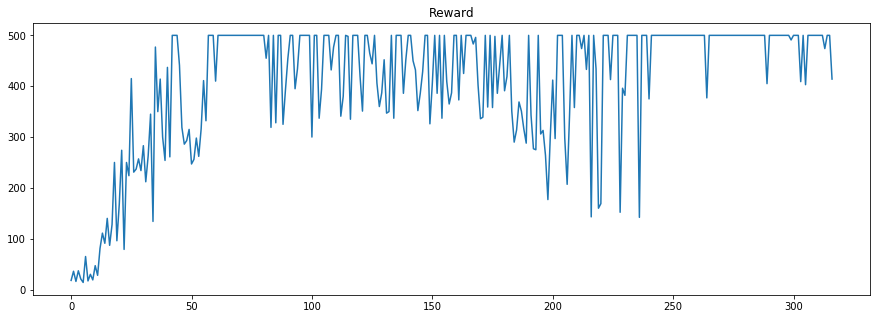

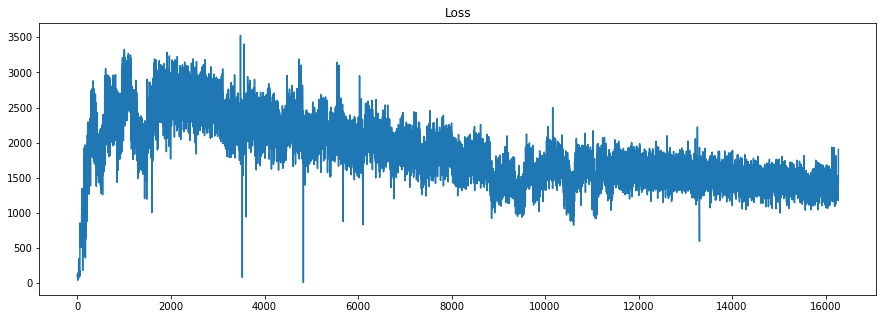

In [7]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(ep_rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [8]:
[
    ('CartPole-v0', 186, 3, 4),
    ('CartPole-v1', 277, 3, 4),
    ('MountainCar-v0', None),
    ('LunarLander-v2', None)
]

[('CartPole-v0', 186, 3, 4),
 ('CartPole-v1', 277, 3, 4),
 ('MountainCar-v0', None),
 ('LunarLander-v2', None)]